# 목차
1. 필요한 라이브러리 임포트 및 설정
2. 데이터 로드 및 전처리
    - 2.1 MHealth 데이터셋 로드 및 전처리 (재실행 가능하도록 수정)
    - 2.2 데이터 검증 및 전처리
3. MergeData.csv 데이터 처리 및 전처리
    - 3.1 MergeData.csv를 Parquet로 변환하여 저장 (재실행 가능하도록 수정)
    - 3.2 데이터 검증 및 전처리
4. 데이터셋 결합 및 스케일링 (재실행 가능하도록 수정)
5. 데이터셋 분할 및 데이터 검증
6. 모델 정의 및 학습
    - 6.1 MobileNetV2 1D 모델 구현
    - 6.2 모델 프루닝 적용
    - 6.3 지식 증류(Knowledge Distillation) 적용
    - 6.4 모델 학습 (재실행 가능하도록 수정)
7. 모델 저장 및 배포를 위한 최적화
    - 7.1 모델 양자화 및 TorchScript 변환
8. 실시간 예측 함수 구현 및 최적화
9. MergeData.parquet 데이터에 대한 예측 및 레이블 추가 (재실행 가능하도록 수정)
    - 9.1 MergeData.parquet 데이터 로드 및 예측
    - 9.2 예측 결과 저장 (Parquet 형식)
10. 마무리 및 저장

# 1. 필요한 라이브러리 임포트 및 설정

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import prune
from torch.utils.data import Dataset, DataLoader
from torch.quantization import quantize_dynamic
import torch.jit  # TorchScript 변환을 위해 필요

import warnings
import logging
import gc  # 가비지 컬렉션을 위해 필요

import pyarrow as pa
import pyarrow.parquet as pq

warnings.filterwarnings('ignore')  # 경고 메시지 무시

# 로깅 설정
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[
                        logging.FileHandler("training_optimized.log"),
                        logging.StreamHandler()
                    ])
logger = logging.getLogger()

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"사용 중인 디바이스: {device}")
if device.type == 'cuda':
    logger.info(f"GPU 이름: {torch.cuda.get_device_name(0)}")

# 저장 디렉토리 생성
os.makedirs('./real_time_model_optimized', exist_ok=True)

2024-10-21 04:50:03,795 - INFO - 사용 중인 디바이스: cuda
2024-10-21 04:50:03,799 - INFO - GPU 이름: NVIDIA GeForce GTX 1650


# 2. 데이터 로드 및 전처리
***
## 2.1 MHealth 데이터셋 로드 및 전처리

In [2]:
# 체크포인트 파일 경로
mhealth_processed_file = './real_time_model_optimized/mhealth_processed.npz'

if os.path.exists(mhealth_processed_file):
    # 이전에 처리된 데이터가 있으면 로드
    logger.info("이전에 처리된 MHealth 데이터를 로드합니다.")
    data = np.load(mhealth_processed_file)
    X_raw_mhealth = data['X_raw_mhealth']
    y_raw_mhealth = data['y_raw_mhealth']
    logger.info("MHealth 데이터 로드 완료.")
else:
    # 데이터 파일 경로 설정
    data_files = glob.glob('./data/MHEALTHDATASET/mHealth_subject*.log')

    # 데이터와 레이블을 저장할 리스트 초기화
    X_list = []
    y_list = []

    logger.info("MHealth 데이터셋을 로드합니다...")
    for file in tqdm(data_files, desc="Loading MHealth Files"):
        # 필요한 열만 로드하여 메모리 사용량을 줄입니다.
        data = pd.read_csv(file,
                           sep='\s+',
                           header=None,
                           usecols=[17, 18, 19, 23],
                           dtype=np.float32)
        data.dropna(inplace=True)  # 결측값 제거

        # 데이터 검증: 이상치 제거
        data = data[(data.iloc[:, :3] >= -50).all(axis=1) & (data.iloc[:, :3] <= 50).all(axis=1)]

        # 우측 하완 센서의 자이로스코프 데이터 추출 (열 17~19)
        right_arm_gyro = data.iloc[:, :3].values  # 열 17~19

        # 레이블 추출 (열 23)
        labels = data.iloc[:, 3].values  # 열 23

        # null 클래스(레이블 0)는 제외
        valid_indices = labels != 0
        sensor_data = right_arm_gyro[valid_indices, :]
        labels = labels[valid_indices]

        # 데이터와 레이블 저장
        X_list.append(sensor_data)
        y_list.append(labels)

        # 메모리에서 데이터 제거
        del data, right_arm_gyro, labels, sensor_data, valid_indices
        gc.collect()

    logger.info("MHealth 데이터 로드 및 전처리 완료.")

    # 리스트를 배열로 변환
    X_raw_mhealth = np.vstack(X_list)
    y_raw_mhealth = np.hstack(y_list)

    # 메모리에서 리스트 제거
    del X_list, y_list
    gc.collect()

    # 레이블을 0부터 시작하도록 조정
    y_raw_mhealth = y_raw_mhealth - 1  # 레이블이 1부터 시작하므로 0부터 시작하도록 조정

    logger.info(f"MHealth 데이터 크기: {X_raw_mhealth.shape}")
    logger.info(f"MHealth 레이블 크기: {y_raw_mhealth.shape}")

    # 처리된 데이터를 저장
    np.savez_compressed(mhealth_processed_file,
                        X_raw_mhealth=X_raw_mhealth,
                        y_raw_mhealth=y_raw_mhealth)
    logger.info("처리된 MHealth 데이터를 저장했습니다.")

2024-10-21 04:50:03,819 - INFO - MHealth 데이터셋을 로드합니다...
Loading MHealth Files: 100%|████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]
2024-10-21 04:50:11,568 - INFO - MHealth 데이터 로드 및 전처리 완료.
2024-10-21 04:50:11,637 - INFO - MHealth 데이터 크기: (343195, 3)
2024-10-21 04:50:11,637 - INFO - MHealth 레이블 크기: (343195,)
2024-10-21 04:50:11,711 - INFO - 처리된 MHealth 데이터를 저장했습니다.


## 2.2 데이터 검증 및 전처리

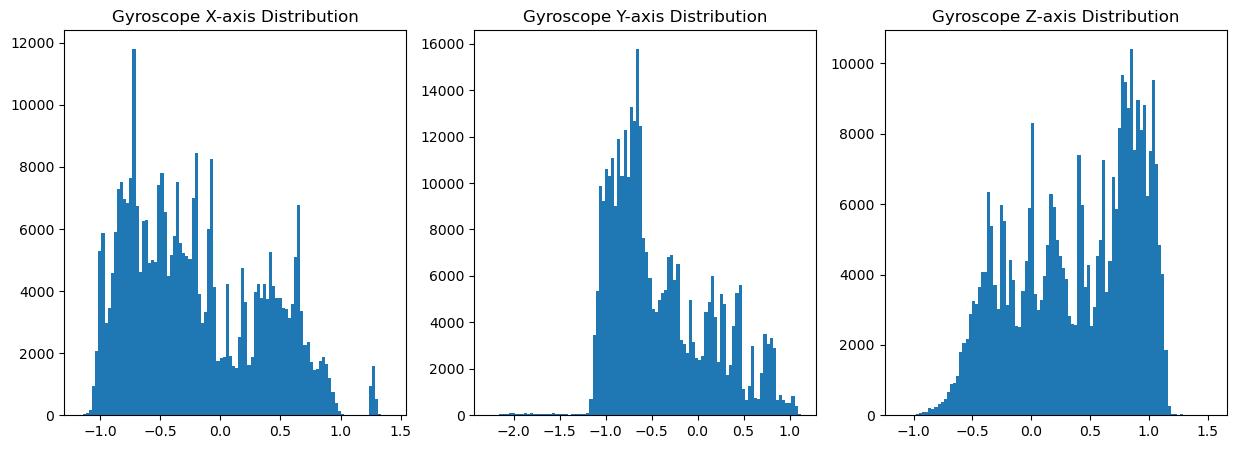

2024-10-21 04:50:12,587 - INFO - MHealth 데이터 분포 히스토그램을 저장했습니다.


In [3]:
# 데이터 분포 확인
if not os.path.exists('./real_time_model_optimized/mhealth_histograms.png'):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.hist(X_raw_mhealth[:, 0], bins=100)
    plt.title('Gyroscope X-axis Distribution')

    plt.subplot(1, 3, 2)
    plt.hist(X_raw_mhealth[:, 1], bins=100)
    plt.title('Gyroscope Y-axis Distribution')

    plt.subplot(1, 3, 3)
    plt.hist(X_raw_mhealth[:, 2], bins=100)
    plt.title('Gyroscope Z-axis Distribution')

    plt.savefig('./real_time_model_optimized/mhealth_histograms.png')
    plt.show()
    logger.info("MHealth 데이터 분포 히스토그램을 저장했습니다.")
else:
    logger.info("MHealth 데이터 분포 히스토그램이 이미 존재합니다. 생략합니다.")

# 3. MergeData.csv 데이터 처리 및 전처리
***
## 3.1 MergeData.csv를 Parquet로 변환하여 저장

In [4]:
# CSV에서 Parquet로 변환
csv_file = './data/MergeData.csv'
parquet_file = './real_time_model_optimized/MergeData.parquet'

if not os.path.exists(parquet_file):
    logger.info("MergeData.csv를 Parquet 형식으로 변환합니다...")
    chunksize = 10 ** 6  # 1,000,000 행씩 처리

    reader = pd.read_csv(csv_file, chunksize=chunksize,
                         usecols=['VitalDate',
                                  'WorkDate',
                                  'UserCode',
                                  'HeartBeat',
                                  'Temperature',
                                  'OutsideTemperature',
                                  'Latitude',
                                  'Longitude',
                                  'X',
                                  'Y',
                                  'Z'],
                         dtype={'VitalDate': 'object',
                                'WorkDate': 'object',
                                'UserCode': 'int32',
                                'HeartBeat': 'float32',
                                'Temperature': 'float32',
                                'OutsideTemperature': 'float32',
                                'Latitude': 'float64',
                                'Longitude': 'float64',
                                'X': 'float32',
                                'Y': 'float32',
                                'Z': 'float32'})

    writer = None

    for i, chunk in enumerate(tqdm(reader, desc="Converting CSV to Parquet")):
        chunk.dropna(inplace=True)
        valid_indices = (chunk[['X', 'Y', 'Z']] >= -1000).all(axis=1) & (chunk[['X', 'Y', 'Z']] <= 1000).all(axis=1)
        chunk = chunk[valid_indices]
        chunk.reset_index(drop=True, inplace=True)

        if not chunk.empty:
            table = pa.Table.from_pandas(chunk)

            if writer is None:
                writer = pq.ParquetWriter(parquet_file, table.schema)

            writer.write_table(table)

            # 메모리에서 청크 제거
            del chunk, valid_indices, table
            gc.collect()
        else:
            logger.warning(f"청크 {i}에 유효한 데이터가 없습니다. 이 청크는 건너뜁니다.")

    if writer:
        writer.close()
        logger.info("CSV에서 Parquet로의 변환이 완료되었습니다.")
    else:
        logger.error("유효한 데이터가 없어 Parquet 파일을 생성하지 못했습니다.")
else:
    logger.info("Parquet 파일이 이미 존재합니다. 변환을 생략합니다.")

2024-10-21 04:50:12,598 - INFO - MergeData.csv를 Parquet 형식으로 변환합니다...
Converting CSV to Parquet: 276it [08:36,  1.87s/it]
2024-10-21 04:58:49,350 - INFO - CSV에서 Parquet로의 변환이 완료되었습니다.


## 3.2 데이터 검증 및 전처리

2024-10-21 04:58:49,379 - INFO - MergeData.parquet에서 데이터를 로드하여 검증합니다.


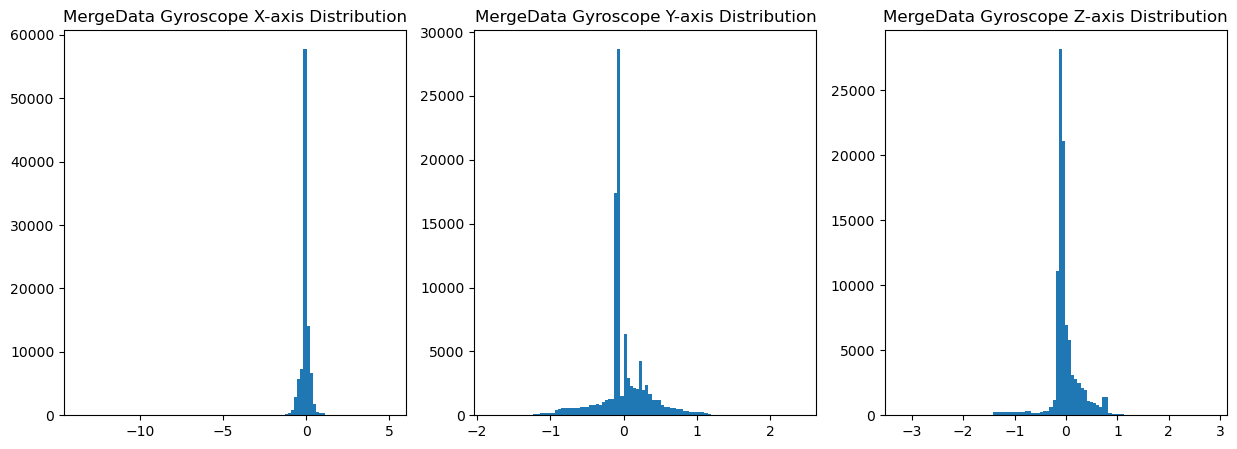

2024-10-21 04:58:50,229 - INFO - MergeData 데이터 분포 히스토그램을 저장했습니다.


In [5]:
histogram_file = './real_time_model_optimized/merge_data_histograms.png'

if not os.path.exists(histogram_file):
    logger.info("MergeData.parquet에서 데이터를 로드하여 검증합니다.")
    parquet = pq.ParquetFile(parquet_file)

    # 첫 번째 row group만 읽기
    table = parquet.read_row_groups([0], columns=['X', 'Y', 'Z'])

    # Pandas DataFrame으로 변환
    df_sample = table.to_pandas()

    # 필요한 행 수만큼 슬라이싱
    df_sample = df_sample.head(100000)

    # 데이터 분포 확인
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.hist(df_sample['X'], bins=100)
    plt.title('MergeData Gyroscope X-axis Distribution')

    plt.subplot(1, 3, 2)
    plt.hist(df_sample['Y'], bins=100)
    plt.title('MergeData Gyroscope Y-axis Distribution')

    plt.subplot(1, 3, 3)
    plt.hist(df_sample['Z'], bins=100)
    plt.title('MergeData Gyroscope Z-axis Distribution')

    plt.savefig(histogram_file)
    plt.show()
    logger.info("MergeData 데이터 분포 히스토그램을 저장했습니다.")

    # 메모리에서 샘플 데이터 제거
    del df_sample, table, parquet
    gc.collect()
else:
    logger.info("MergeData 데이터 분포 히스토그램이 이미 존재합니다. 생략합니다.")

# 4. 데이터셋 결합 및 스케일링

In [6]:
# 체크포인트 파일 경로
combined_data_file = './real_time_model_optimized/combined_data.npz'
scaler_file = './real_time_model_optimized/scaler.pkl'

if os.path.exists(combined_data_file) and os.path.exists(scaler_file):
    logger.info("이전에 결합된 데이터와 스케일러를 로드합니다.")
    data = np.load(combined_data_file)
    X_scaled = data['X_scaled']
    y_total = data['y_total']
    scaler = joblib.load(scaler_file)
    logger.info("결합된 데이터와 스케일러 로드 완료.")
else:
    # MHealth 데이터와 MergeData 결합
    logger.info("MHealth 데이터와 MergeData를 결합합니다.")
    parquet_file = './real_time_model_optimized/MergeData.parquet'

    X_list_merge = []

    parquet = pq.ParquetFile(parquet_file)
    num_row_groups = parquet.num_row_groups

    for i in tqdm(range(num_row_groups), desc="Loading MergeData.parquet"):
        table = parquet.read_row_groups([i], columns=['X', 'Y', 'Z'])
        df_chunk = table.to_pandas()
        gyro_data = df_chunk[['X', 'Y', 'Z']].values.astype(np.float32)
        X_list_merge.append(gyro_data)

        # 메모리에서 데이터 제거
        del df_chunk, gyro_data, table
        gc.collect()

    X_raw_merge = np.vstack(X_list_merge)
    logger.info(f"MergeData 데이터 크기: {X_raw_merge.shape}")

    # 메모리에서 리스트 제거
    del X_list_merge
    gc.collect()

    # 데이터 결합
    X_total = np.vstack((X_raw_mhealth, X_raw_merge))
    y_total = np.hstack((y_raw_mhealth, np.full(X_raw_merge.shape[0], -1, dtype=int)))  # MergeData의 레이블은 -1로 표시

    # 메모리에서 원본 데이터 제거
    del X_raw_mhealth, X_raw_merge, y_raw_mhealth
    gc.collect()

    logger.info(f"결합된 데이터 크기: {X_total.shape}")
    logger.info(f"결합된 레이블 크기: {y_total.shape}")

    # 스케일링
    logger.info("데이터를 스케일링합니다.")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_total)

    # 스케일러 및 데이터 저장
    joblib.dump(scaler, scaler_file)
    np.savez_compressed(combined_data_file,
                        X_scaled=X_scaled,
                        y_total=y_total)
    logger.info("스케일러와 결합된 데이터를 저장했습니다.")

    # 메모리에서 원본 데이터 제거
    del X_total
    gc.collect()

2024-10-21 04:58:50,322 - INFO - MHealth 데이터와 MergeData를 결합합니다.
Loading MergeData.parquet: 100%|██████████████████████████████| 276/276 [00:29<00:00,  9.21it/s]
2024-10-21 04:59:20,941 - INFO - MergeData 데이터 크기: (275980458, 3)
2024-10-21 04:59:24,027 - INFO - 결합된 데이터 크기: (276323653, 3)
2024-10-21 04:59:24,028 - INFO - 결합된 레이블 크기: (276323653,)
2024-10-21 04:59:24,028 - INFO - 데이터를 스케일링합니다.
2024-10-21 05:01:47,873 - INFO - 스케일러와 결합된 데이터를 저장했습니다.


# 5. 데이터셋 분할 및 데이터 검증

2024-10-21 05:01:48,881 - INFO - 레이블이 있는 데이터 크기: (343195, 3)
2024-10-21 05:01:49,224 - INFO - 데이터를 학습 및 검증 세트로 분할합니다.


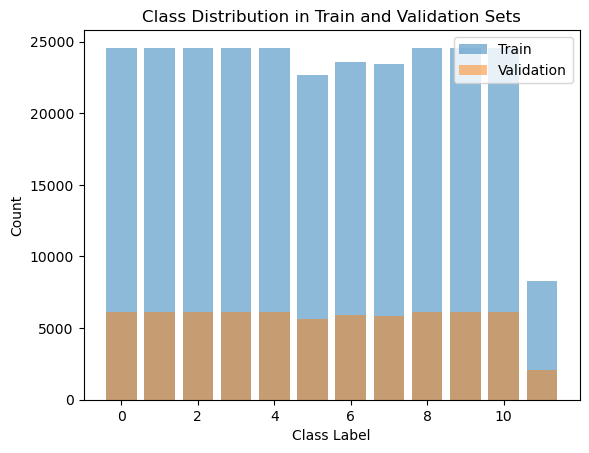

2024-10-21 05:01:49,587 - INFO - 데이터 분포 그래프를 저장했습니다.


In [7]:
# 레이블이 있는 데이터만 분리
X_labeled = X_scaled[y_total != -1]
y_labeled = y_total[y_total != -1].astype(int)

logger.info(f"레이블이 있는 데이터 크기: {X_labeled.shape}")

# 메모리에서 사용하지 않는 변수 제거
del y_total, X_scaled
gc.collect()

# 학습 및 검증 데이터 분할
logger.info("데이터를 학습 및 검증 세트로 분할합니다.")
X_train, X_val, y_train, y_val = train_test_split(
    X_labeled,
    y_labeled,
    test_size=0.2,
    random_state=42,
    stratify=y_labeled
)

# 메모리에서 사용하지 않는 변수 제거
del X_labeled, y_labeled
gc.collect()

# 학습 데이터와 검증 데이터의 분포 비교
train_labels, train_counts = np.unique(y_train, return_counts=True)
val_labels, val_counts = np.unique(y_val, return_counts=True)

distribution_file = './real_time_model_optimized/data_distribution.png'
if not os.path.exists(distribution_file):
    plt.bar(train_labels, train_counts, alpha=0.5, label='Train')
    plt.bar(val_labels, val_counts, alpha=0.5, label='Validation')
    plt.legend()
    plt.xlabel('Class Label')
    plt.ylabel('Count')
    plt.title('Class Distribution in Train and Validation Sets')
    plt.savefig(distribution_file)
    plt.show()
    logger.info("데이터 분포 그래프를 저장했습니다.")
else:
    logger.info("데이터 분포 그래프가 이미 존재합니다. 생략합니다.")

# 6. 모델 정의 및 학습
***
## 6.1 MobileNetV2 1D 모델 구현

In [8]:
class InvertedResidual1D(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual1D, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # 확장 단계
            layers.append(nn.Conv1d(inp, hidden_dim, kernel_size=1, bias=False))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU6(inplace=True))
            
        # 깊이별 컨볼루션
        layers.extend([
            nn.Conv1d(hidden_dim,
                      hidden_dim,
                      kernel_size=3, 
                      stride=stride,
                      padding=1,
                      groups=hidden_dim,
                      bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU6(inplace=True),
            # 투영 단계
            nn.Conv1d(hidden_dim,
                      oup,
                      kernel_size=1, 
                      bias=False),
            nn.BatchNorm1d(oup),
        ])
        self.conv = nn.Sequential(*layers)
        self.out_channels = oup

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2_1D(nn.Module):
    def __init__(self, num_classes=12, width_mult=1.0):
        super(MobileNetV2_1D, self).__init__()
        block = InvertedResidual1D
        input_channel = 32
        last_channel = 1280

        # 설정된 configuration
        inverted_residual_setting = [
            # t(expand_ratio), c(output channels), n(number of blocks), s(stride)
            [1, 16, 1, 1],
            [6, 24, 2, 1],  # stride를 1로 설정하여 입력 데이터의 길이가 너무 작아지지 않도록 합니다.
            [6, 32, 3, 2],
            [6, 64, 4, 1],
            [6, 96, 3, 1],
            [6, 160, 3, 1],
            [6, 320, 1, 1],
        ]

        # 첫 번째 레이어
        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * max(1.0, width_mult))
        features = [nn.Conv1d(3,
                              input_channel,
                              kernel_size=3,
                              stride=1,
                              padding=1,
                              bias=False),
                    nn.BatchNorm1d(input_channel),
                    nn.ReLU6(inplace=True)]

        # inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel

        # 마지막 몇 개 레이어
        features.append(nn.Conv1d(input_channel, self.last_channel, kernel_size=1, bias=False))
        features.append(nn.BatchNorm1d(self.last_channel))
        features.append(nn.ReLU6(inplace=True))

        self.features = nn.Sequential(*features)

        # 분류를 위한 풀링과 fully connected layer
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight 초기화
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        # 글로벌 평균 풀링
        x = F.adaptive_avg_pool1d(x, 1).reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

- MobileNetV2의 모든 블록을 1D 버전으로 구현하였습니다.
- 입력 데이터의 길이가 너무 작아지지 않도록 일부 stride를 1로 설정하였습니다.
- 자이로스코프 데이터(X, Y, Z 축)를 입력으로 받으므로 입력 채널 수는 3입니다.
- 클래스 수는 MHealth 데이터셋의 활동 수인 12로 설정하였습니다.

## 6.2 모델 프루닝 적용

In [9]:
# 프루닝을 적용할 함수 정의
def apply_pruning(model, amount=0.3):
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
            parameters_to_prune.append((module, 'weight'))

    # 글로벌 프루닝 적용
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )

    # 프루닝 후 마스크 제거 (속도 향상을 위해)
    for module, _ in parameters_to_prune:
        prune.remove(module, 'weight')

# 모델 초기화
num_classes = 12  # MHealth 데이터셋의 활동 수
model = MobileNetV2_1D(num_classes=num_classes)
model.to(device)

# 모델 프루닝 적용
apply_pruning(model, amount=0.3)
logger.info("Model pruning applied with 30% sparsity.")

2024-10-21 05:01:50,452 - INFO - Model pruning applied with 30% sparsity.


- apply_pruning 함수를 정의하여 모델에 프루닝을 적용합니다.
- amount=0.3으로 설정하여 전체 가중치의 30%를 제거합니다.
- 프루닝 후 마스크를 제거하여 추론 속도를 향상시킵니다.

## 6.3 지식 증류(Knowledge Distillation) 적용

In [10]:
# Teacher 모델 (이미 학습된 모델 사용)
teacher_model_file = './real_time_model_optimized/teacher_model.pth'

if os.path.exists(teacher_model_file):
    teacher_model = MobileNetV2_1D(num_classes=num_classes)
    teacher_model.load_state_dict(torch.load(teacher_model_file))
    teacher_model.to(device)
    teacher_model.eval()
    logger.info("Teacher 모델을 로드했습니다.")
else:
    # Teacher 모델 학습 (필요한 경우)
    logger.info("Teacher 모델을 학습합니다...")
    # 여기서는 간단히 동일한 모델을 학습한다고 가정합니다.
    # 실제로는 더 큰 모델이나 더 오래 학습된 모델을 사용할 수 있습니다.

    # 데이터셋 및 데이터로더 생성
    class SimpleDataset(Dataset):
        def __init__(self, X, y):
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.long)

        def __len__(self):
            return len(self.y)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    train_dataset = SimpleDataset(X_train, y_train)
    val_dataset = SimpleDataset(X_val, y_val)

    batch_size = 1024
    train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=0,  # Jupyter 환경에서는 0으로 설정
                              pin_memory=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=0,
                            pin_memory=True)

    teacher_model = MobileNetV2_1D(num_classes=num_classes)
    teacher_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(teacher_model.parameters(), lr=0.001)

    num_epochs = 100
    best_val_loss = float('inf')

    logger.info("Starting Teacher model training...")
    for epoch in range(num_epochs):
        # 학습 모드
        teacher_model.train()
        total_loss = 0
        total_correct = 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            X_batch = X_batch.unsqueeze(-1)  # 또는 X_batch = X_batch.view(batch_size, 3, 1)

            optimizer.zero_grad()

            outputs = teacher_model(X_batch)
            loss = criterion(outputs, y_batch)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)
            total_correct += (preds == y_batch).sum().item()

            # 메모리에서 변수 제거
            del X_batch, y_batch, outputs, loss, preds
            torch.cuda.empty_cache()

        train_loss = total_loss / len(train_dataset)
        train_acc = total_correct / len(train_dataset)

        # 검증 모드
        teacher_model.eval()
        total_loss = 0
        total_correct = 0

        with torch.no_grad():
            for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                X_batch = X_batch.unsqueeze(-1)  # (batch_size, 3, 1)

                outputs = teacher_model(X_batch)
                loss = criterion(outputs, y_batch)

                total_loss += loss.item() * X_batch.size(0)
                _, preds = torch.max(outputs, 1)
                total_correct += (preds == y_batch).sum().item()

                # 메모리에서 변수 제거
                del X_batch, y_batch, outputs, loss, preds
                torch.cuda.empty_cache()

        val_loss = total_loss / len(val_dataset)
        val_acc = total_correct / len(val_dataset)

        # 검증 손실이 개선되었는지 확인하고 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(teacher_model.state_dict(), teacher_model_file)
            logger.info(f"Epoch {epoch+1}: 검증 손실이 개선되어 Teacher 모델을 저장했습니다. Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
        else:
            logger.info(f"Epoch {epoch+1}: 검증 손실이 개선되지 않았습니다. Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

        # 에포크 결과 출력
        logger.info(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
                    f"Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, "
                    f"Val Acc: {val_acc*100:.2f}%")

        # 메모리에서 변수 제거
        gc.collect()
        torch.cuda.empty_cache()

    teacher_model.eval()
    logger.info("Teacher 모델 학습 완료 및 저장했습니다.")

2024-10-21 05:01:50,479 - INFO - Teacher 모델을 학습합니다...
2024-10-21 05:01:56,313 - INFO - Starting Teacher model training...
2024-10-21 05:02:17,965 - INFO - Epoch 1: 검증 손실이 개선되어 Teacher 모델을 저장했습니다. Val Loss: 0.7818, Val Acc: 73.03%
2024-10-21 05:02:17,966 - INFO - Epoch [1/100], Train Loss: 0.9069, Train Acc: 69.08%, Val Loss: 0.7818, Val Acc: 73.03%
2024-10-21 05:02:38,347 - INFO - Epoch 2: 검증 손실이 개선되어 Teacher 모델을 저장했습니다. Val Loss: 0.7143, Val Acc: 75.31%
2024-10-21 05:02:38,347 - INFO - Epoch [2/100], Train Loss: 0.7195, Train Acc: 74.97%, Val Loss: 0.7143, Val Acc: 75.31%
2024-10-21 05:02:58,776 - INFO - Epoch 3: 검증 손실이 개선되어 Teacher 모델을 저장했습니다. Val Loss: 0.6874, Val Acc: 76.48%
2024-10-21 05:02:58,776 - INFO - Epoch [3/100], Train Loss: 0.6722, Train Acc: 76.53%, Val Loss: 0.6874, Val Acc: 76.48%
2024-10-21 05:03:19,206 - INFO - Epoch 4: 검증 손실이 개선되어 Teacher 모델을 저장했습니다. Val Loss: 0.6229, Val Acc: 78.12%
2024-10-21 05:03:19,207 - INFO - Epoch [4/100], Train Loss: 0.6397, Train Acc: 77.5

## 6.4 모델 학습

In [11]:
# Student 모델 (경량화된 모델)
student_model = MobileNetV2_1D(num_classes=num_classes,
                               width_mult=0.5)  # 모델 크기를 줄임
student_model.to(device)

# 손실 함수 정의
criterion = nn.CrossEntropyLoss()
distillation_criterion = nn.KLDivLoss(reduction='batchmean')

optimizer = torch.optim.Adam(student_model.parameters(), lr=0.001)

# Student 모델 학습 체크포인트 파일 경로
student_model_file = './real_time_model_optimized/best_student_model.pth'
training_checkpoint = './real_time_model_optimized/training_checkpoint.pth'

if os.path.exists(student_model_file):
    logger.info("Best Student 모델이 이미 존재합니다. 학습을 생략합니다.")
    student_model.load_state_dict(torch.load(student_model_file))
else:
    # 데이터셋 및 데이터로더 생성 (이미 생성되었다면 생략)
    if 'train_loader' not in globals():
        class SimpleDataset(Dataset):
            def __init__(self, X, y):
                self.X = torch.tensor(X, dtype=torch.float32)
                self.y = torch.tensor(y, dtype=torch.long)

            def __len__(self):
                return len(self.y)

            def __getitem__(self, idx):
                return self.X[idx], self.y[idx]

        train_dataset = SimpleDataset(X_train, y_train)
        val_dataset = SimpleDataset(X_val, y_val)

        batch_size = 1024
        train_loader = DataLoader(train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=0,  # Jupyter 환경에서는 0으로 설정
                                  pin_memory=True)
        val_loader = DataLoader(val_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=0,
                                pin_memory=True)

    # 지식 증류를 위한 학습 루프
    num_epochs = 100
    best_val_loss = float('inf')
    patience = 5
    counter = 0
    temperature = 5.0  # 온도 매개변수
    start_epoch = 0

    # 이전에 저장된 체크포인트가 있으면 로드
    if os.path.exists(training_checkpoint):
        checkpoint = torch.load(training_checkpoint)
        student_model.load_state_dict(checkpoint['student_model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        best_val_loss = checkpoint['best_val_loss']
        counter = checkpoint['counter']
        start_epoch = checkpoint['epoch'] + 1
        logger.info(f"이전 체크포인트를 로드했습니다. Epoch {start_epoch}부터 시작합니다.")

    logger.info("Starting knowledge distillation training...")
    for epoch in range(start_epoch, num_epochs):
        # 학습 모드
        student_model.train()
        total_loss = 0
        total_correct = 0

        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # 입력 데이터 차원 조정
            X_batch = X_batch.unsqueeze(-1)  # (batch_size, 3, 1)

            optimizer.zero_grad()

            # Teacher 모델 예측
            with torch.no_grad():
                teacher_outputs = teacher_model(X_batch)

            # Student 모델 예측
            student_outputs = student_model(X_batch)

            # 손실 계산
            loss_ce = criterion(student_outputs, y_batch)
            loss_kd = distillation_criterion(
                F.log_softmax(student_outputs / temperature, dim=1),
                F.softmax(teacher_outputs / temperature, dim=1)
            ) * (temperature ** 2)
            loss = loss_ce + loss_kd

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(student_outputs, 1)
            total_correct += (preds == y_batch).sum().item()

            # 메모리에서 변수 제거
            del X_batch, y_batch, teacher_outputs, student_outputs, loss_ce, loss_kd, loss, preds
            torch.cuda.empty_cache()

        train_loss = total_loss / len(train_dataset)
        train_acc = total_correct / len(train_dataset)

        # 검증 모드
        student_model.eval()
        total_loss = 0
        total_correct = 0

        with torch.no_grad():
            for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                X_batch = X_batch.unsqueeze(-1)  # (batch_size, 3, 1)

                outputs = student_model(X_batch)
                loss = criterion(outputs, y_batch)

                total_loss += loss.item() * X_batch.size(0)
                _, preds = torch.max(outputs, 1)
                total_correct += (preds == y_batch).sum().item()

                # 메모리에서 변수 제거
                del X_batch, y_batch, outputs, loss, preds
                torch.cuda.empty_cache()

        val_loss = total_loss / len(val_dataset)
        val_acc = total_correct / len(val_dataset)

        # 검증 손실이 개선되었는지 확인하고 모델 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(student_model.state_dict(), student_model_file)
            counter = 0
            logger.info(f"Epoch {epoch+1}: 검증 손실이 개선되어 Student 모델을 저장했습니다. Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
        else:
            counter += 1
            logger.info(f"Epoch {epoch+1}: 검증 손실이 개선되지 않았습니다. Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
            if counter >= patience:
                logger.info("조기 종료 조건에 도달하여 학습을 종료합니다.")
                break

        # 에포크 결과 출력
        logger.info(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, "
                    f"Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, "
                    f"Val Acc: {val_acc*100:.2f}%")

        # 체크포인트 저장
        torch.save({
            'epoch': epoch,
            'student_model_state_dict': student_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'counter': counter,
        }, training_checkpoint)
        logger.info("체크포인트를 저장했습니다.")

        # 메모리에서 변수 제거
        gc.collect()
        torch.cuda.empty_cache()

    # 학습 완료 후 체크포인트 삭제
    if os.path.exists(training_checkpoint):
        os.remove(training_checkpoint)
        logger.info("학습 완료 후 체크포인트를 삭제했습니다.")

2024-10-21 05:36:10,754 - INFO - Starting knowledge distillation training...
2024-10-21 05:36:35,584 - INFO - Epoch 1: 검증 손실이 개선되어 Student 모델을 저장했습니다. Val Loss: 0.9416, Val Acc: 70.99%
2024-10-21 05:36:35,585 - INFO - Epoch [1/100], Train Loss: 5.4359, Train Acc: 63.00%, Val Loss: 0.9416, Val Acc: 70.99%
2024-10-21 05:36:35,658 - INFO - 체크포인트를 저장했습니다.
2024-10-21 05:37:00,469 - INFO - Epoch 2: 검증 손실이 개선되어 Student 모델을 저장했습니다. Val Loss: 0.8306, Val Acc: 73.31%
2024-10-21 05:37:00,470 - INFO - Epoch [2/100], Train Loss: 3.0325, Train Acc: 71.73%, Val Loss: 0.8306, Val Acc: 73.31%
2024-10-21 05:37:00,541 - INFO - 체크포인트를 저장했습니다.
2024-10-21 05:37:25,371 - INFO - Epoch 3: 검증 손실이 개선되어 Student 모델을 저장했습니다. Val Loss: 0.7479, Val Acc: 75.37%
2024-10-21 05:37:25,371 - INFO - Epoch [3/100], Train Loss: 2.5389, Train Acc: 73.57%, Val Loss: 0.7479, Val Acc: 75.37%
2024-10-21 05:37:25,443 - INFO - 체크포인트를 저장했습니다.
2024-10-21 05:37:50,279 - INFO - Epoch 4: 검증 손실이 개선되어 Student 모델을 저장했습니다. Val Loss: 0.7059, 

# 7. 모델 저장 및 배포를 위한 최적화
***
## 7.1 모델 양자화 및 TorchScript 변환

In [12]:
# 가장 좋은 Student 모델 로드 (CPU에 로드)
student_model.load_state_dict(torch.load('./real_time_model_optimized/best_student_model.pth', map_location='cpu'))
student_model.eval()

# 모델을 CPU로 이동
student_model.to('cpu')

# 모델의 모든 파라미터가 CPU에 있는지 확인
for param in student_model.parameters():
    assert param.device.type == 'cpu', "모델 파라미터가 CPU에 있지 않습니다."

# 양자화 적용
quantized_model = quantize_dynamic(
    student_model,  # 모델 객체
    {nn.Linear},  # 양자화할 모듈 타입
    dtype=torch.qint8  # 양자화 데이터 타입
)

# TorchScript로 변환하여 저장
example_input = torch.randn(1, 3, 1)  # 예시 입력 데이터 (CPU 텐서)
traced_script_module = torch.jit.trace(quantized_model, example_input)

traced_script_module.save('./real_time_model_optimized/model_scripted.pt')
logger.info("TorchScript 모델을 './real_time_model_optimized/model_scripted.pt'로 저장했습니다.")

2024-10-21 05:44:29,767 - INFO - TorchScript 모델을 './real_time_model_optimized/model_scripted.pt'로 저장했습니다.


# 8. 실시간 예측 함수 구현 및 최적화

In [13]:
def real_time_predict(model, scaler, data_point):
    """
    실시간으로 단일 데이터 포인트를 예측합니다.

    Parameters:
        model (torch.jit.ScriptModule): TorchScript로 변환된 모델.
        scaler (object): 스케일러 객체.
        data_point (numpy array): (1, num_features) 형태의 데이터 포인트.

    Returns:
        str: 예측된 활동 이름.
    """
    
    model.eval()
    data_point_scaled = scaler.transform(data_point)
    data_tensor = torch.tensor(data_point_scaled, dtype=torch.float32)
    data_tensor = data_tensor.unsqueeze(-1)  # (1, 3, 1)
    
    with torch.no_grad():
        output = model(data_tensor)
        _, pred = torch.max(output, 1)
    class_names = ['Standing',
                   'Sitting',
                   'Lying',
                   'Walking',
                   'Climbing Stairs',
                   'Waist Bends Forward',
                   'Frontal Elevation of Arms',
                   'Knees Bending',
                   'Cycling',
                   'Jogging',
                   'Running',
                   'Jumping Front & Back']
    return class_names[pred.item()]

# 스케일러 및 TorchScript 모델 로드
scaler = joblib.load('./real_time_model_optimized/scaler.pkl')

# 모델 로드 (CPU에 로드)
model = torch.jit.load('./real_time_model_optimized/model_scripted.pt', map_location='cpu')
model.eval()

# 모델이 CPU에 있는지 확인
for param in model.parameters():
    assert param.device.type == 'cpu', "모델 파라미터가 CPU에 있지 않습니다."

# 실시간 데이터 포인트 (예시)
new_data_point = np.array([[0.1, -0.05, 0.03]])  # 자이로스코프 X, Y, Z 값

# 예측
predicted_activity = real_time_predict(model,
                                       scaler,
                                       new_data_point)
print(f"예측된 활동: {predicted_activity}")

예측된 활동: Climbing Stairs


# 9. MergeData.parquet 데이터에 대한 예측 및 레이블 추가
***
## 9.1 MergeData.parquet 데이터 로드 및 예측

In [14]:
output_file = './real_time_model_optimized/MergeData_Prediction.parquet'
progress_file = './real_time_model_optimized/prediction_progress.txt'

# 스케일러 및 모델 로드
scaler = joblib.load('./real_time_model_optimized/scaler.pkl')

# 모델 로드 (CPU에 로드)
model = torch.jit.load('./real_time_model_optimized/model_scripted.pt', map_location='cpu')
model.eval()

logger.info("MergeData.parquet 파일에 대한 예측을 시작합니다...")
parquet_file = './real_time_model_optimized/MergeData.parquet'

# Parquet 파일의 총 행 수 계산
parquet_file_reader = pq.ParquetFile(parquet_file)
nrows = parquet_file_reader.metadata.num_rows

chunksize = 10 ** 6  # 청크 크기 설정
total_chunks = (nrows + chunksize - 1) // chunksize

# 이전에 처리한 청크 인덱스 확인
if os.path.exists(progress_file):
    with open(progress_file, 'r') as f:
        start_chunk = int(f.read())
    logger.info(f"{start_chunk}번째 청크부터 재개합니다.")
else:
    start_chunk = 0

# 결과를 Parquet 파일로 저장하기 위해 ParquetWriter를 사용
writer = None

for chunk_idx in tqdm(range(start_chunk, total_chunks), desc="Predicting MergeData.parquet"):
    start = chunk_idx * chunksize
    end = min((chunk_idx + 1) * chunksize, nrows)

    table = parquet_file_reader.read_row_groups([chunk_idx])
    df_chunk = table.to_pandas()

    gyro_data = df_chunk[['X', 'Y', 'Z']].values.astype(np.float32)

    # 스케일링
    gyro_data_scaled = scaler.transform(gyro_data)

    # 데이터 텐서로 변환
    data_tensor = torch.tensor(gyro_data_scaled, dtype=torch.float32)
    data_tensor = data_tensor.unsqueeze(-1)  # (batch_size, 3, 1)

    # 모델 예측
    with torch.no_grad():
        output = model(data_tensor)
        _, preds = torch.max(output, 1)

    # 예측 결과를 클래스 이름으로 변환
    class_names = ['Standing',
                   'Sitting',
                   'Lying',
                   'Walking',
                   'Climbing Stairs',
                   'Waist Bends Forward',
                   'Frontal Elevation of Arms',
                   'Knees Bending',
                   'Cycling',
                   'Jogging',
                   'Running',
                   'Jumping Front & Back']
    predicted_activities = [class_names[pred.item()] for pred in preds]

    # 예측 결과를 데이터프레임에 추가
    df_chunk['Activity'] = predicted_activities

    # 결과를 Parquet 파일로 저장
    table = pa.Table.from_pandas(df_chunk)
    if writer is None:
        writer = pq.ParquetWriter(output_file, table.schema)
    writer.write_table(table)

    # 진행 상황 저장
    with open(progress_file, 'w') as f:
        f.write(str(chunk_idx + 1))

    # 메모리에서 데이터 제거
    del df_chunk, gyro_data, gyro_data_scaled, data_tensor, output, preds, predicted_activities, table
    gc.collect()

if writer:
    writer.close()

# 진행 상황 파일 삭제
if os.path.exists(progress_file):
    os.remove(progress_file)

logger.info("MergeData.parquet 파일에 대한 예측이 완료되었습니다.")

2024-10-21 05:44:30,184 - INFO - MergeData.parquet 파일에 대한 예측을 시작합니다...
Predicting MergeData.parquet: 100%|█████████████████████████| 276/276 [2:48:08<00:00, 36.55s/it]
2024-10-21 08:32:38,574 - INFO - MergeData.parquet 파일에 대한 예측이 완료되었습니다.


## 9.2 예측 결과 저장 (Parquet 형식)

In [15]:
parquet_file = './real_time_model_optimized/MergeData_Prediction.parquet'

# Parquet 파일이 존재하는지 확인
if os.path.exists(parquet_file):
    # Parquet 파일 로드
    df = pd.read_parquet(parquet_file)
    logger.info("예측 결과를 Parquet 파일에서 로드했습니다.")

    # 필요한 경우 CSV로 저장
    csv_file = './real_time_model_optimized/MergeData_Prediction.csv'
    df.to_csv(csv_file, index=False)
    logger.info(f"예측 결과를 CSV 파일로 저장했습니다: {csv_file}")
else:
    logger.error(f"Parquet 파일이 존재하지 않습니다: {parquet_file}")

2024-10-21 08:35:54,586 - INFO - 예측 결과를 Parquet 파일에서 로드했습니다.
2024-10-21 09:11:23,250 - INFO - 예측 결과를 CSV 파일로 저장했습니다: ./real_time_model_optimized/MergeData_Prediction.csv
